# D(St)reams of Anomalies

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

## Exploratory Data Analysis

Let's look at the traffic dataset for the Minnesota Twin Cities metro. This is real data, collected by the Minnesota Department of Transportation. Unlike some of the other datasets from the NAB suite, the sources of the anomalies are unkown (or, at least, not provided). The data is broken apart into several different CSV files.

In [31]:
occupancy_6005 = pd.read_csv('../data/occupancy_6005.csv')
occupancy_6005.head()

,timestamp,value
0,2015-09-01 13:45:00,3.06
1,2015-09-01 13:50:00,6.44
2,2015-09-01 13:55:00,5.17
3,2015-09-01 14:00:00,3.83
4,2015-09-01 14:05:00,4.50


In [32]:
occupancy_t4013 = pd.read_csv('../data/occupancy_t4013.csv')
occupancy_t4013.head()

,timestamp,value
0,2015-09-01 11:30:00,13.56
1,2015-09-01 11:35:00,8.33
2,2015-09-01 11:40:00,11.78
3,2015-09-01 11:55:00,15.28
4,2015-09-01 12:00:00,10.06


It is not immediately clear why these two occupancy datasets are separated, nor is it clear the meaning of the suffixes "6005" and "t4013". The NAB `README` states "metrics include occupancy, speed, and travel time from specific sensors," so perhaps these refer to specific sensors. To unify the two, I will join them together with a tag denoting the originating sensor. The datasets for speed and travel time appear similarily striated by sensor, and I will combine them in the same way.

In [33]:
occupancy_6005['sensor']  = '6005'
occupancy_t4013['sensor'] = 't4013'

occupancy = pd.concat([occupancy_6005, occupancy_t4013], ignore_index=True)
occupancy.head()

,timestamp,value,sensor
0,2015-09-01 13:45:00,3.06,6005
1,2015-09-01 13:50:00,6.44,6005
2,2015-09-01 13:55:00,5.17,6005
3,2015-09-01 14:00:00,3.83,6005
4,2015-09-01 14:05:00,4.50,6005


In [34]:
speed_6005  = pd.read_csv('../data/speed_6005.csv')
speed_7578  = pd.read_csv('../data/speed_7578.csv')
speed_t4013 = pd.read_csv('../data/speed_t4013.csv')

speed_6005['sensor']  = '6005'
speed_7578['sensor']  = '7578'
speed_t4013['sensor'] = 't4013'

speed = pd.concat([speed_6005, speed_7578, speed_t4013], ignore_index=True)
speed.head()

,timestamp,value,sensor
0,2015-08-31 18:22:00,90,6005
1,2015-08-31 18:32:00,80,6005
2,2015-08-31 18:57:00,84,6005
3,2015-08-31 19:07:00,94,6005
4,2015-08-31 19:12:00,90,6005


In [50]:
traveltime_387 = pd.read_csv('../data/TravelTime_387.csv')
traveltime_451 = pd.read_csv('../data/TravelTime_451.csv')

traveltime_387['sensor'] = '_387'
traveltime_451['sensor'] = '_451'

traveltime = pd.concat([traveltime_387, traveltime_451], ignore_index=True)
traveltime.head()

,timestamp,value,sensor
0,2015-07-10 14:24:00,564,_387
1,2015-07-10 14:38:00,730,_387
2,2015-07-10 14:48:00,770,_387
3,2015-07-10 15:03:00,910,_387
4,2015-07-10 15:22:00,1035,_387


Now that we have consolidated our data, let's parse the timestamp into something we can reason about, sort chronologically, and view our three time series.

In [36]:
def parse_timestamp(s : str) -> datetime:
    [date, time] = s.split()
    [year, month, day] = date.split('-')
    [hour, minute, second] = time.split(':')
    return datetime.datetime(year=int(year), month=int(month), day=int(day),
                             hour=int(hour),minute=int(minute), second=int(second))

In [37]:
occupancy['timestamp']  = occupancy['timestamp'].apply(parse_timestamp)
speed['timestamp']      = speed['timestamp'].apply(parse_timestamp)
traveltime['timestamp'] = traveltime['timestamp'].apply(parse_timestamp)

occupancy.sort_values('timestamp')
speed.sort_values('timestamp')
traveltime.sort_values('timestamp')

,timestamp,value,sensor
0,2015-07-10 14:24:00,564,_387
1,2015-07-10 14:38:00,730,_387
2,2015-07-10 14:48:00,770,_387
3,2015-07-10 15:03:00,910,_387
4,2015-07-10 15:22:00,1035,_387
...,...,...,...
2497,2015-09-17 16:50:00,271,_387
2498,2015-09-17 17:00:00,308,_387
4660,2015-09-17 17:00:00,216,_451
4661,2015-09-17 17:09:00,209,_451


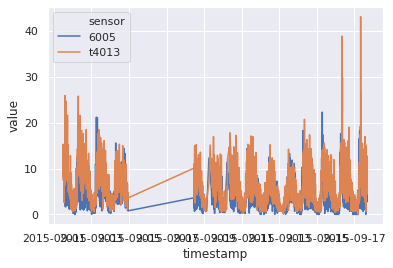

In [38]:
sns.set()
sns.lineplot(data=occupancy, x='timestamp', y='value', hue='sensor')

It appears the values for both sensors generally follow the same shape, modulo a couple spikes here and there (potentially anomalies).

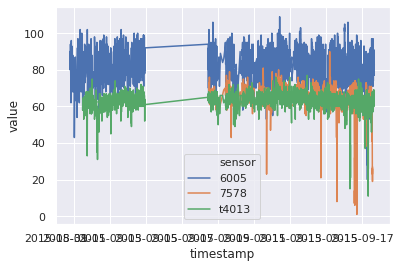

In [39]:
sns.lineplot(data=speed, x='timestamp', y='value', hue='sensor')

In the case of the speed data, the sensors actually do appear to make a signficant difference. The value of the first sensor is generally larger, but also has a greater amplitude than the others, and the second has a smaller time frame.

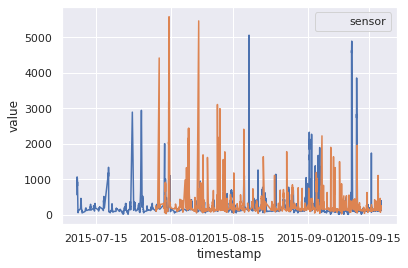

In [40]:
sns.lineplot(data=traveltime, x='timestamp', y='value', hue='sensor')

As for travel time, it appears the baseline is similar across both sensors, but the spikes don't coincide whatsoever.

## Feature Engineering

Now, let us consider what additional features we might be able to extract from the timestamps. Certainly, the time of day, time of week, and time of year will all impact traffic. We can expect more volume and congestion around rush hour, weekends, and near holidays. Since this data is local to Minnesota, we should also note the winter months when heavy snow has a chance to slow things down.

In [41]:
for df in [occupancy, speed, traveltime]:
    df['month'] = df['timestamp'].apply(lambda t: t.month -1)
    df['day']   = df['timestamp'].apply(lambda t: t.day -1)
    df['time']  = df['timestamp'].apply(lambda t: t.second + 60 * (t.minute + 60 * t.hour))
    
    df['winter'] = df['month'].apply(lambda m: 1 if m == 11 or m <= 1 else 0)
    df['spring'] = df['month'].apply(lambda m: 1 if 2 <= m <= 4  else 0)
    df['summer'] = df['month'].apply(lambda m: 1 if 5 <= m <= 7  else 0)
    df['fall']   = df['month'].apply(lambda m: 1 if 8 <= m <= 10 else 0)

    weekdays = pd.get_dummies(df['timestamp'].apply(lambda d: d.weekday()))
    weekday_columns = list(map(lambda w: "W_"+str(w), weekdays.columns))
    df[weekday_columns] = weekdays
    
occupancy.head()

,timestamp,value,sensor,month,day,time,winter,spring,summer,fall,W_0,W_1,W_2,W_3,W_4,W_5,W_6
0,2015-09-01 13:45:00,3.06,6005,8,0,49500,0,0,0,1,0,1,0,0,0,0,0
1,2015-09-01 13:50:00,6.44,6005,8,0,49800,0,0,0,1,0,1,0,0,0,0,0
2,2015-09-01 13:55:00,5.17,6005,8,0,50100,0,0,0,1,0,1,0,0,0,0,0
3,2015-09-01 14:00:00,3.83,6005,8,0,50400,0,0,0,1,0,1,0,0,0,0,0
4,2015-09-01 14:05:00,4.50,6005,8,0,50700,0,0,0,1,0,1,0,0,0,0,0


Here, we have extracted the month and day, shifted downward to start at zero, as well as one-hot encoded seasons and weekdays. Furthermore, we have a "time" attribute which is simply the number of seconds since the start of the day. This is a convenient format for representing time of day within a model, with high granularity. Note that there is no feature for the year, since all data occurs in 2015.

Finally, we need to remove the timestamp, which is python object and therefore unusable by the model, and also we need to one-hot encode the sensor data.

In [42]:
occupancy_input  = occupancy.copy()
speed_input      = speed.copy()
traveltime_input = traveltime.copy()

occupancy_input = occupancy_input.join(pd.get_dummies(occupancy_input['sensor']))
speed_input = speed_input.join(pd.get_dummies(speed_input['sensor']))
traveltime_input = traveltime_input.join(pd.get_dummies(traveltime_input['sensor']))

del occupancy_input['timestamp']
del speed_input['timestamp']
del traveltime_input['timestamp']

del occupancy_input['sensor']
del speed_input['sensor']
del traveltime_input['sensor']

## Modeling

In [43]:
from sklearn.ensemble import IsolationForest

Let's try to apply an isolation forest to these datasets to identify anomalies.

In [44]:
model = IsolationForest(behaviour='new', contamination='auto')
occupancy['anomaly'] = model.fit_predict(occupancy_input)

In [45]:
occupancy['anomaly'] = occupancy['anomaly'].apply(lambda x: 'yes' if x == -1 else 'no').astype('category')
occupancy.head()

,timestamp,value,sensor,month,day,time,winter,spring,summer,fall,W_0,W_1,W_2,W_3,W_4,W_5,W_6,anomaly
0,2015-09-01 13:45:00,3.06,6005,8,0,49500,0,0,0,1,0,1,0,0,0,0,0,yes
1,2015-09-01 13:50:00,6.44,6005,8,0,49800,0,0,0,1,0,1,0,0,0,0,0,yes
2,2015-09-01 13:55:00,5.17,6005,8,0,50100,0,0,0,1,0,1,0,0,0,0,0,yes
3,2015-09-01 14:00:00,3.83,6005,8,0,50400,0,0,0,1,0,1,0,0,0,0,0,yes
4,2015-09-01 14:05:00,4.50,6005,8,0,50700,0,0,0,1,0,1,0,0,0,0,0,yes


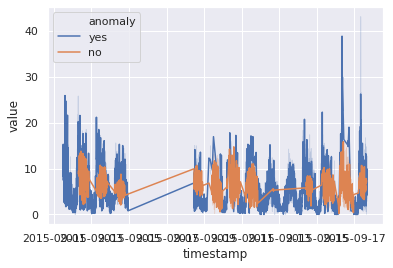

In [46]:
sns.lineplot(data=occupancy, x='timestamp', y='value', hue='anomaly', hue_order=['yes','no'])

This first attempt appears to overdiagnoes anamolies. Let's try again, but this time setting the ratio of anomalies manually.

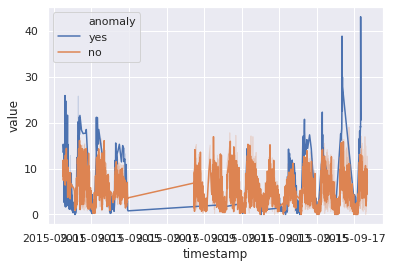

In [47]:
model = IsolationForest(behaviour='new', contamination=.1)
occupancy['anomaly'] = model.fit_predict(occupancy_input)
occupancy['anomaly'] = occupancy['anomaly'].apply(lambda x: 'yes' if x == -1 else 'no').astype('category')
sns.lineplot(data=occupancy, x='timestamp', y='value', hue='anomaly', hue_order=['yes','no'])

This looks like a much more balanced and intuitive distinction between "normal" and "anomalous". Let's apply this strategy to the next two datasets. 

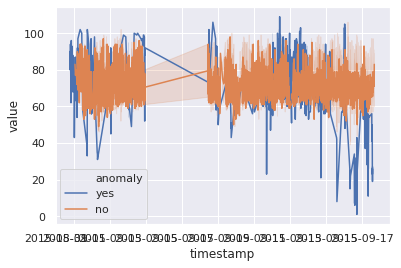

In [48]:
model = IsolationForest(behaviour='new', contamination=.1)
speed['anomaly'] = model.fit_predict(speed_input)
speed['anomaly'] = speed['anomaly'].apply(lambda x: 'yes' if x == -1 else 'no').astype('category')
sns.lineplot(data=speed, x='timestamp', y='value', hue='anomaly', hue_order=['yes','no'])

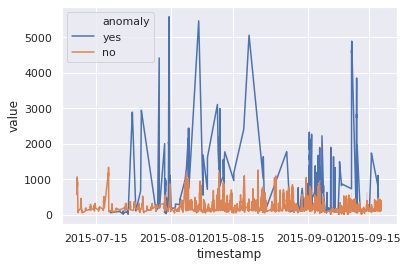

In [49]:
model = IsolationForest(behaviour='new', contamination=.1)
traveltime['anomaly'] = model.fit_predict(traveltime_input)
traveltime['anomaly'] = traveltime['anomaly'].apply(lambda x: 'yes' if x == -1 else 'no').astype('category')
sns.lineplot(data=traveltime, x='timestamp', y='value', hue='anomaly', hue_order=['yes','no'])

## Conclusion
This dataset did not indicate which points are anomalous. Therefore, it is difficult to evaluate the success of our models. However, looking at the graphs, I feel that the isolation forest algorithm, when provided with an anomaly ratio, very succesfully identified outliers in the three datasets.